# Timing methods

This notebook demonstrates some of the "quick-look" timing analyses available in `opticam`.

## Preface

`stingray` is designed primarily for analysing X-ray data, and so is perhaps not ideal for OPTICAM data products. That said, `stingray` provides a number of useful routines that can (mostly) be applied to arbitrary time series, provided some care is taken.

## Generating and Reducing Data

Before we can explore the different timing analyses provided in `opticam`, we need some light curves to analyse. For this example, I'll generate some gappy observations, and then reduce them following the steps outlined in the [Reduction Tutorial](reduction.ipynb). We'll need some pretty long light curves, which means we'll need to generate a lot of images. As such, I'll use `binning_scale=8` to ensure the generated images do not take up a large amount of disk space: 

[OPTICAM] variable source is at (61, 52)


Generating observations: 100%|██████████|[00:19<00:00]

[OPTICAM] timing_analysis_tutorial/reduced not found, attempting to create ...
[OPTICAM] timing_analysis_tutorial/reduced created.



[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]
/home/zac/miniforge3/envs/opticam/lib/python3.12/site-packages/opticam/utils/data_checks.py:201: UserWarning: [OPTICAM] Large time gap detected between 240101g200000078o.fits.gz and 240101g200000093o.fits.gz (34.997 s compared to the median time difference of 1.000 s). This may cause alignment issues. If so, consider moving all files after this gap to a separate directory.
  warnings.warn(string)
/home/zac/miniforge3/envs/opticam/lib/python3.12/site-packages/opticam/utils/data_checks.py:201: UserWarning: [OPTICAM] Large time gap detected between 240101g200000485o.fits.gz and 240101g200000389o.fits.gz (41.996 s compared to the median time difference of 1.000 s). This may cause alignment issues. If so, consider moving all files after this gap to a separate directory.
  warnings.warn(string)
/home/zac/miniforge3/envs/opticam/lib/python3.12/site-packages/opticam/utils/data_checks.py:201: UserWarning: [OPTICAM] Large time gap

[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 354 g-band images.
[OPTICAM] 354 r-band images.
[OPTICAM] 354 i-band images.


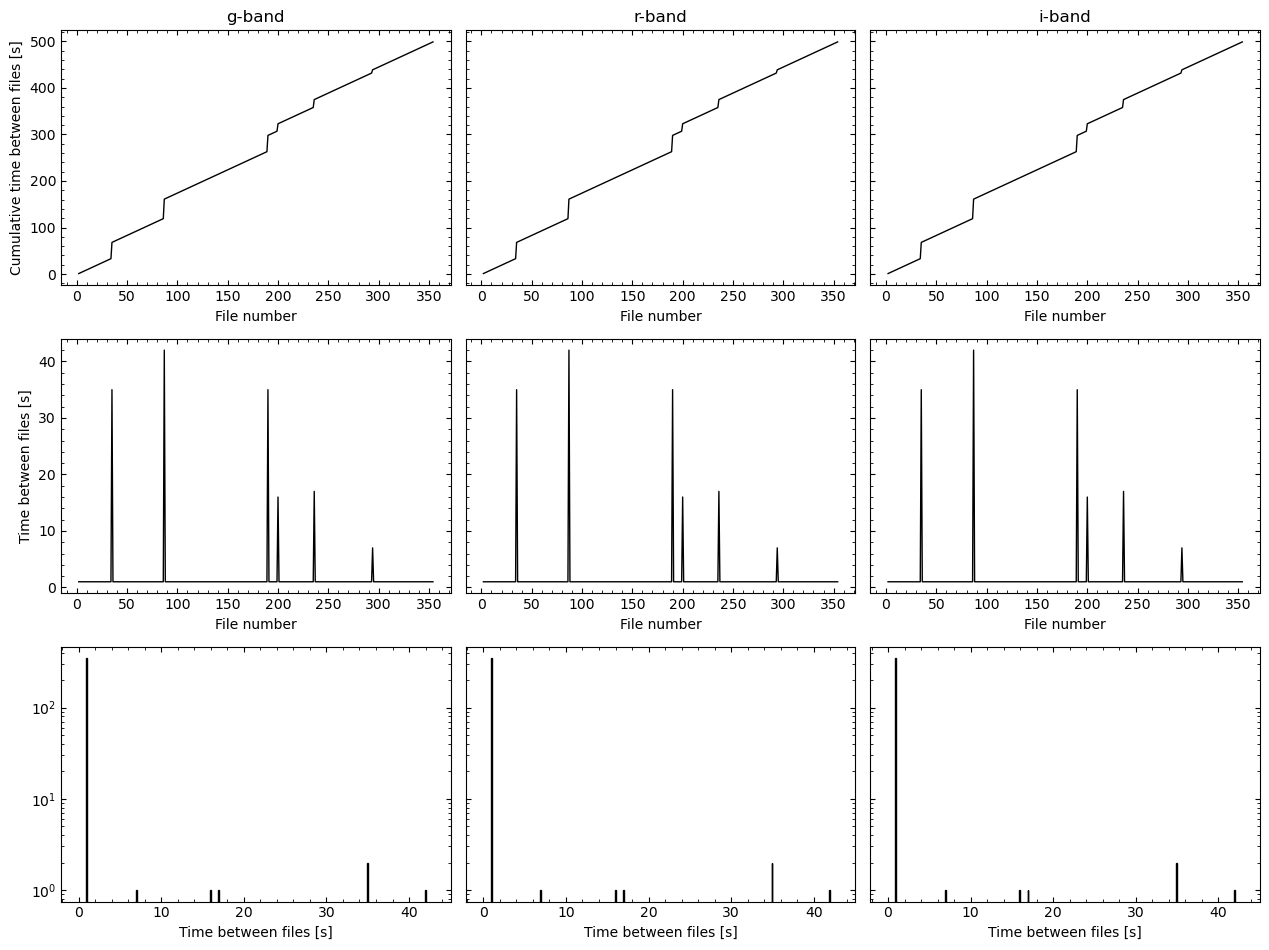

[OPTICAM] Creating source catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 354 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 354 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 354 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


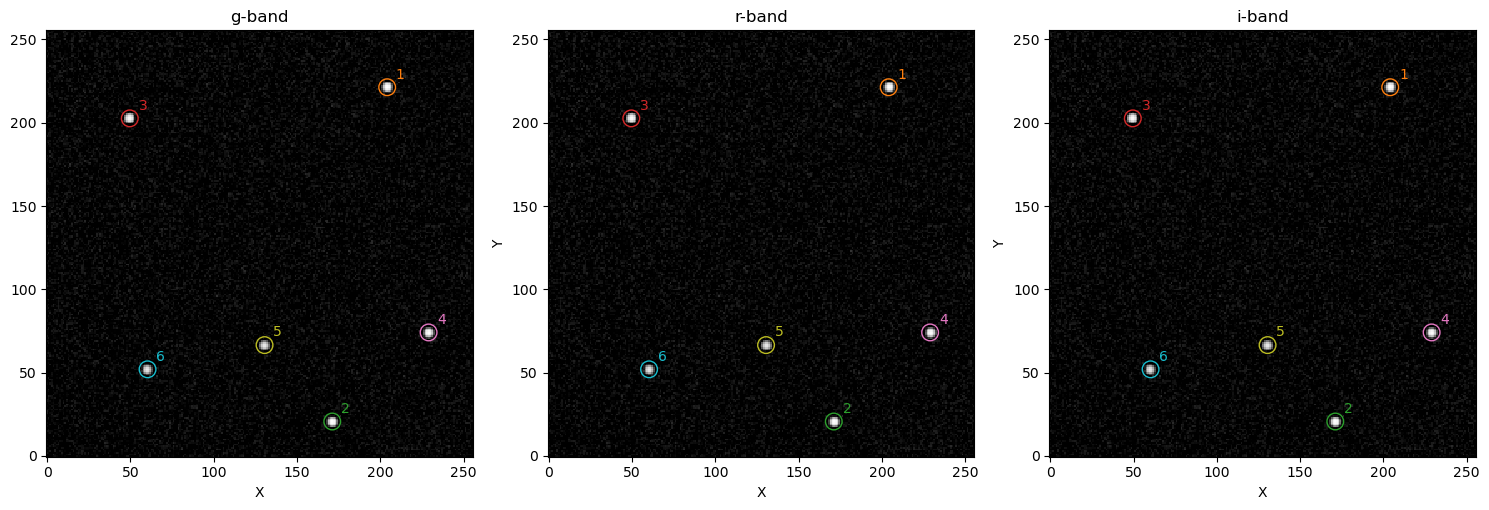

[OPTICAM] Photometry results will be saved to optimal_light_curves in timing_analysis_tutorial/reduced.


/home/zac/miniforge3/envs/opticam/lib/python3.12/site-packages/opticam/photometers.py:49: UserWarning: [OPTICAM] from version 0.3.0, "match_sources" will be renamed to "forced". "forced=False" will function the same as "match_sources=True".
  warnings.warn('[OPTICAM] from version 0.3.0, "match_sources" will be renamed to "forced". "forced=False" will function the same as "match_sources=True".')
[OPTICAM] Performing photometry on g-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on r-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on i-band images: 100%|██████████|[00:00<00:00]


In [1]:
import opticam

opticam.generate_gappy_observations(
    out_dir='timing_analysis_tutorial/data',
    n_images=500,
    binning_scale=8,
    circular_aperture=False,  # disable circular aperture shadow for simplicity
)

reducer = opticam.Reducer(
    data_directory='timing_analysis_tutorial/data',
    out_directory='timing_analysis_tutorial/reduced',
    show_plots=True,
    verbose=True,
    remove_cosmic_rays=False,
    )
reducer.create_catalogs()

phot = opticam.OptimalPhotometer()
reducer.photometry(phot)

[OPTICAM] Filters: g-band, r-band, i-band


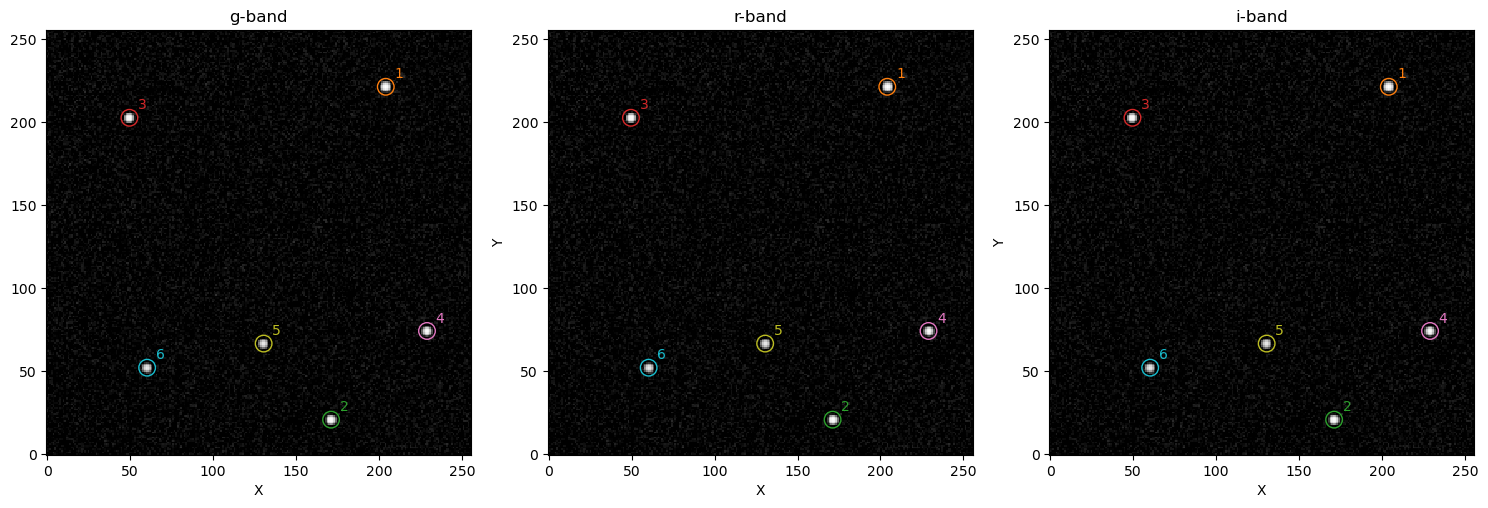

In [2]:
dphot = opticam.DifferentialPhotometer(
    out_directory='timing_analysis_tutorial/reduced',
)

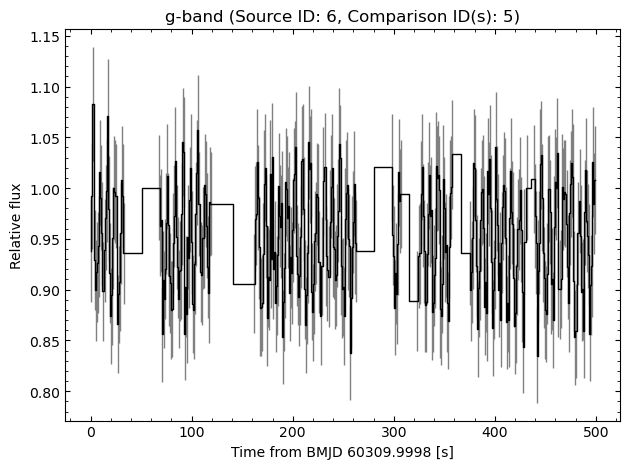

[OPTICAM] g-band target ID 6 was matched to r-band target ID 6
[OPTICAM] g-band comparison ID 5 was matched to r-band comparison ID 5


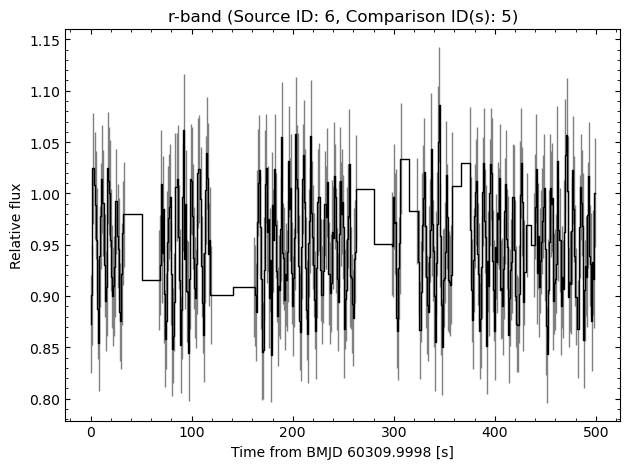

[OPTICAM] g-band target ID 6 was matched to i-band target ID 6
[OPTICAM] g-band comparison ID 5 was matched to i-band comparison ID 5


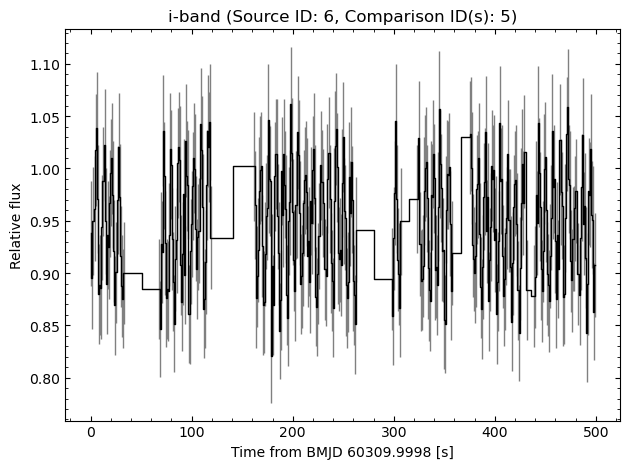

/home/zac/miniforge3/envs/opticam/lib/python3.12/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [3]:
analyser = dphot.get_relative_light_curve(
    fltr='g-band',
    target=6,
    comparisons=5,
    phot_label='optimal',
    match_other_cameras=True,
    show_diagnostics=False,
)

We now have an `Analyzer` instance that provides a number of quick-look timing analyses routines. Under-the-hood, these routines use the `stingray` Python package, so if a particular `stingray` routine is not implemented in `opticam`, a light curve from the `Analyzer` instance can be passed directly to `stingray` instead (more on this later). By using `stingray`, the results returned by `opticam.Analyzer` methods are intended to be compatible with existing analysis pipelines, or provide a feature-rich framework in which to develop analysis pipelines.

Let's now take a look at the included quick-look routines.

## Periodograms

Often times, users will want to compute the periodograms of their light curves. `stingray` implements both the Lomb-Scargle periodogram (LSP) and the classical periodogram (FFT). Both of these are also implemented in `opticam`.

Since `opticam` computes *relative light curves*, while `stingray` assumes that light curves are in units of counts, any `Analyzer` methods that use `stingray` routines will default to `norm="frac"`. The fractional RMS normalization is valid for relative light curves, while the absolute RMS normalization (`norm="abs"`), will give the same results as the fractional RMS normalisation *provided the light curve is normalised to a mean flux of 1*. In general, users should carefully consider which normalization is most suitable for their purposes.

Let's first take a look at the Lomb-Scargle periodogram:

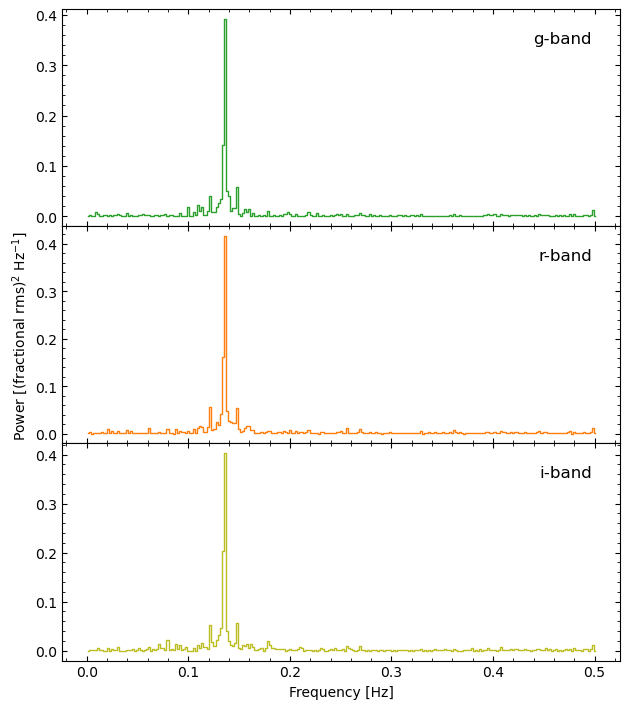

In [4]:
lsps = analyser.compute_lomb_scargle_periodograms()

As we can see, all three bands show a periodicity at 0.135 Hz (which is the true frequency of variability for source 6). We also see a bit of aliasing due to the gaps in our observations. This routine also returns a dictionary of results that may be useful for subsequent analyses:

In [5]:
lsps

{'g-band': <stingray.lombscargle.LombScarglePowerspectrum at 0x7b6e5d625100>,
 'r-band': <stingray.lombscargle.LombScarglePowerspectrum at 0x7b6e5c984fe0>,
 'i-band': <stingray.lombscargle.LombScarglePowerspectrum at 0x7b6f74a6b3e0>}

The dictionary keys list the OPTICAM filters and the values list the corresponding `stingray.lombscargle.LombScarglePowerspectrum` instances.  

Let's compare the LSP to the classical periodogram:

In [6]:
periodograms = analyser.compute_power_spectra()

[OPTICAM] Unable to compute periodogram for g-band light curve due to gaps. Consider using either the compute_lomb_scargle_periodograms() or compute_averaged_power_spectra() methods instead.
[OPTICAM] Unable to compute periodogram for r-band light curve due to gaps. Consider using either the compute_lomb_scargle_periodograms() or compute_averaged_power_spectra() methods instead.
[OPTICAM] Unable to compute periodogram for i-band light curve due to gaps. Consider using either the compute_lomb_scargle_periodograms() or compute_averaged_power_spectra() methods instead.


As we can see, computing the classical periodogram fails because the data contain gaps. Let's try computing the averaged periodogram instead:

[OPTICAM] 2 g-band segments averaged.
[OPTICAM] 2 r-band segments averaged.
[OPTICAM] 2 i-band segments averaged.


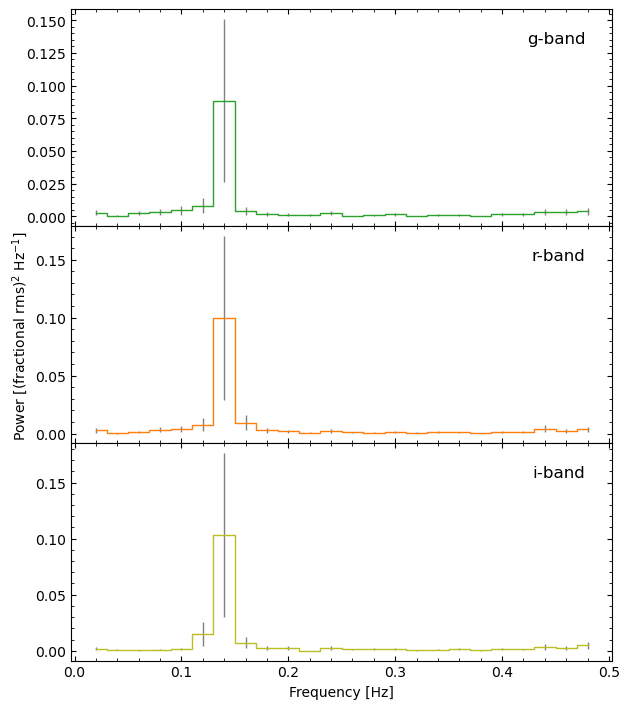

In [7]:
import astropy.units as u

averaged_periodograms = analyser.compute_averaged_power_spectra(
    segment_size=50 * u.s
)

Computing averaged periodograms works, since the gaps can be filtered out, but we don't really have enough data in this case (each averaged periodogram is comprised of just five segments) to get meaningful results. If we did, we could pass the averaged periodograms into a power spectrum modelling framework to make further inferences about the variability.

## Phase Folding

It is also common to phase fold light curves on candidate frequencies or periods to visualise the pulse profile. This is also supported by `opticam` via the `phase_fold_light_curves()` method of `Analyzer`:

In [8]:
print(type(0.135 * u.Hz))

<class 'astropy.units.quantity.Quantity'>


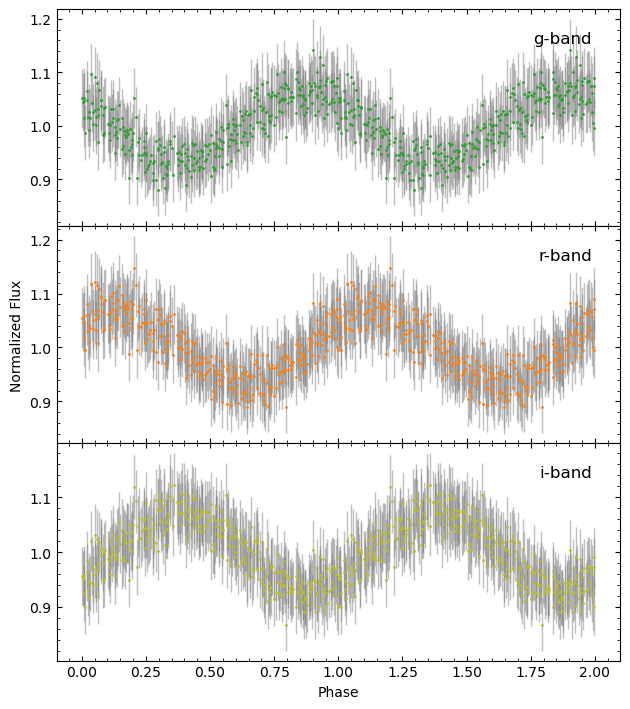

In [9]:
phase_folds = analyser.phase_fold_light_curves(
    period=1 / (0.135 * u.Hz),
)

To avoid issues with units, the `phase_fold_light_curves()` method takes a `period` parameter that must be an `astropy.units.quantity.Quantity` instance.

As we can see, each band shows a sinusoidal periodicity at 0.135 Hz. We can also phase bin to make the pulse profile clearer:

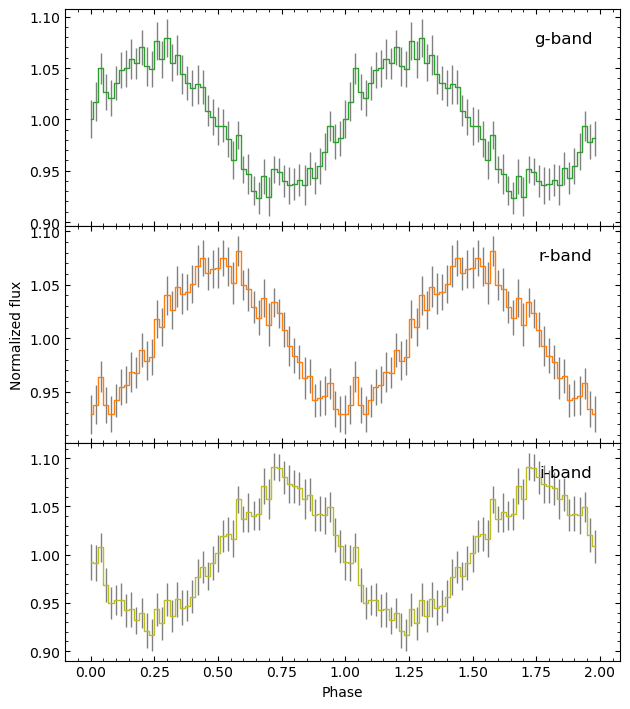

In [10]:
phase_bins = analyser.phase_bin_light_curves(
    period=1 / (0.135 * u.Hz),
    n_bins=50,
)

Now we can see the pulse profiles more clearly. It is also clear from the above plots that there is a lag in the pulsations between the different bands. Let's quantify this.

## Lags

One of the great things about OPTICAM is that it provides simultaneous three-colour observations. As such, it is possible to search for wavelength-dependent lags; `opticam`'s `Analyzer` class makes this easy via the `compute_cross_correlations()` method:

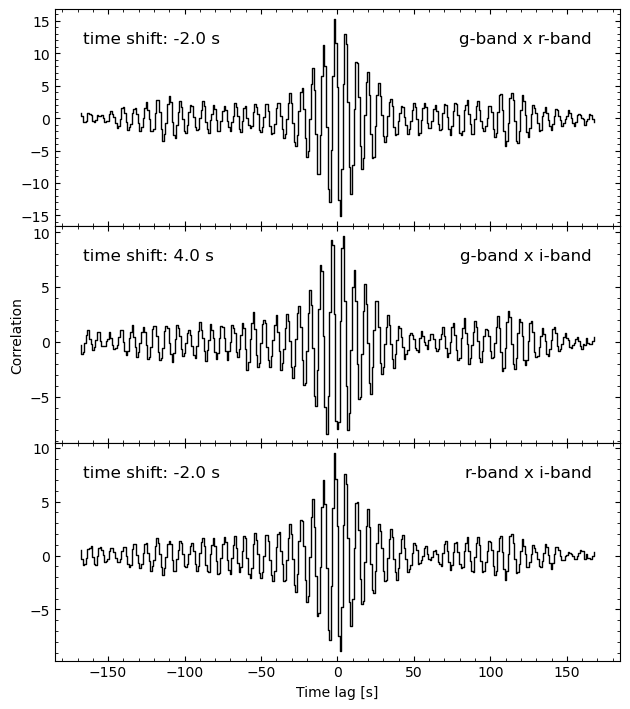

In [11]:
corrs = analyser.compute_cross_correlations()

The `compute_cross_correlations()` method computes the cross-correlations between each pair of light curves in the `Analyzer` instance. As we can see from the above plot, the $r$-band lags the $g$-band by 2 s (since the time shift is negative, the second filter lags the first filter), and the $i$-band lags the $r$-band by 2 s as well. The true lag between these bands is a quarter period; since the period is $1 / 0.135 = 7.4$ s, this is 1.85 s. Within the time resolution of our light curves (1 s), we can therefore correctly recover the lag.

And that concludes the timing methods tutorial for `opticam`! The timing methods demonstrated here are not intended as "quick-look" analyses that can easily be fed to existing `stingray`-based analysis frameworks.